In [13]:
##Libraries
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def bass_diff_eq(
    Below_Baseline, Baseline, Efficient, Cumulative_adopters, par, retirement_rate,
    nc, nc_baseline_share, nc_efficient_share
):
    """
    One Euler step for the Bass diffusion with new construction and retirements.
    """
    # New construction allocation
    nc_baseline = nc * nc_baseline_share
    nc_efficient = nc * nc_efficient_share
    nc_below_baseline = nc - nc_baseline - nc_efficient

    # Total stock before inflows
    total_stock = Below_Baseline + Baseline + Efficient

    # Bass diffusion for upgrades (from retirements only)
    p = par["p"]
    q = par["q"]
    m = total_stock
    # bass_value = (p + q * (Cumulative_adopters / m)) * (m - Cumulative_adopters) / (m * retirement_rate)
    # bass_share = np.clip(bass_value, 0.0, 1.0)
    bass_value = (p + q * (Cumulative_adopters / m)) * (m - Cumulative_adopters)
    bass_share = np.clip((bass_value + Cumulative_adopters) / m, 0.0, 1.0)

    # Retirement flow (all stocks retire at same rate)
    Retirement_Flow = total_stock * retirement_rate

    # Outflows (retirements) proportional to each stock
    out_Below_Baseline = -Retirement_Flow * (Below_Baseline / total_stock) if total_stock > 0 else 0
    out_Baseline = -Retirement_Flow * (Baseline / total_stock) if total_stock > 0 else 0
    out_Efficient = -Retirement_Flow * (Efficient / total_stock) if total_stock > 0 else 0

    # Inflows (adoptions + new construction)
    Efficient_Adoption_Flow = Retirement_Flow * bass_share
    Baseline_Adoption_Flow = Retirement_Flow - Efficient_Adoption_Flow

    # Euler differentials (inflow + NC - outflow)
    dBelow_Baseline_dt = nc_below_baseline + 0 - (-out_Below_Baseline)
    dBaseline_dt = nc_baseline + Baseline_Adoption_Flow - (-out_Baseline)
    dEfficient_dt = nc_efficient + Efficient_Adoption_Flow - (-out_Efficient)
    dadopters_dt = Efficient_Adoption_Flow

    flows = {
        "Retirement": Retirement_Flow,
        "Efficient_Adoption": Efficient_Adoption_Flow,
        "Baseline_Adoption": Baseline_Adoption_Flow,
        "out_Below_Baseline": out_Below_Baseline,
        "out_Baseline": out_Baseline,
        "out_Efficient": out_Efficient,
        "bass_value": bass_value,
        "bass_share": bass_share,
        "Cumulative_adopters": Cumulative_adopters
    }

    return dBelow_Baseline_dt, dBaseline_dt, dEfficient_dt, dadopters_dt, flows

# --- Euler Integration Loop ---

# Parameters
total_years = 20
dt = 1/12
time = np.arange(0, total_years, dt)
n = len(time)
par = {"p": 0.03, "q": 0.38}
retirement_rate = 0.05
nc = 10  # new construction per year (can be array for time-varying)
nc_baseline_share = 0.5
nc_efficient_share = 0.5 # have these be an input that changes over time

# Initialize stocks
Below_Baseline_Stock = np.zeros(n)
Baseline_Stock = np.zeros(n)
Efficient_Stock = np.zeros(n)
Cumulative_adopters = np.zeros(n)

# Initial conditions
Below_Baseline_Stock[0] = 1000 * 0.3
Baseline_Stock[0] = 1000 * 0.5
Efficient_Stock[0] = 1000 * 0.2
Cumulative_adopters[0] = Efficient_Stock[0]

# Initialize flow arrays for plotting
Retirement_Flow_arr = np.zeros(n)
Below_Baseline_Adoption_Flow_arr = np.zeros(n)
Baseline_Adoption_Flow_arr = np.zeros(n)
Efficient_Adoption_Flow_arr = np.zeros(n)
out_Below_Baseline_Adoption_Flow_arr = np.zeros(n)
out_Baseline_Adoption_Flow_arr = np.zeros(n)
out_Efficient_Adoption_Flow_arr = np.zeros(n)
Total_Below_Baseline_Adoption_Flow_arr = np.zeros(n)
Total_Baseline_Adoption_Flow_arr = np.zeros(n)
Total_Efficient_Adoption_Flow_arr = np.zeros(n)
Total_Adoption_Flow_arr = np.zeros(n)      
bass_share_arr = np.zeros(n)             
bass_value_arr = np.zeros(n)            


for t in range(1, n):
    dBelow_Baseline_dt, dBaseline_dt, dEfficient_dt, dadopters_dt, flows = bass_diff_eq(
        Below_Baseline_Stock[t-1],
        Baseline_Stock[t-1],
        Efficient_Stock[t-1],
        Cumulative_adopters[t-1],
        par,
        retirement_rate,
        nc * dt,  # new construction for this step
        nc_baseline_share,
        nc_efficient_share
    )

    # Euler integration
    Below_Baseline_Stock[t] = Below_Baseline_Stock[t-1] + dBelow_Baseline_dt
    Baseline_Stock[t] = Baseline_Stock[t-1] + dBaseline_dt
    Efficient_Stock[t] = Efficient_Stock[t-1] + dEfficient_dt
    Cumulative_adopters[t] = Cumulative_adopters[t-1] + dadopters_dt

    # Enforce non-negativity
    Below_Baseline_Stock[t] = max(Below_Baseline_Stock[t], 0.0)
    Baseline_Stock[t] = max(Baseline_Stock[t], 0.0)
    Efficient_Stock[t] = max(Efficient_Stock[t], 0.0)
    Cumulative_adopters[t] = max(Cumulative_adopters[t], 0.0)

        # Log flows for plotting
    Retirement_Flow_arr[t] = flows["Retirement"]
    Below_Baseline_Adoption_Flow_arr[t] = 0  # No below baseline adoption in this model
    Baseline_Adoption_Flow_arr[t] = flows["Baseline_Adoption"]
    Efficient_Adoption_Flow_arr[t] = flows["Efficient_Adoption"]
    out_Below_Baseline_Adoption_Flow_arr[t] = flows["out_Below_Baseline"]
    out_Baseline_Adoption_Flow_arr[t] = flows["out_Baseline"]
    out_Efficient_Adoption_Flow_arr[t] = flows["out_Efficient"]
    Total_Below_Baseline_Adoption_Flow_arr[t] = dBelow_Baseline_dt
    Total_Baseline_Adoption_Flow_arr[t] = dBaseline_dt
    Total_Efficient_Adoption_Flow_arr[t] = dEfficient_dt
    Total_Adoption_Flow_arr[t] = flows["Efficient_Adoption"] + flows["Baseline_Adoption"]  # Or Retirement_Flow
    bass_share_arr[t] = flows["bass_share"]
    bass_value_arr[t] = flows["bass_value"]


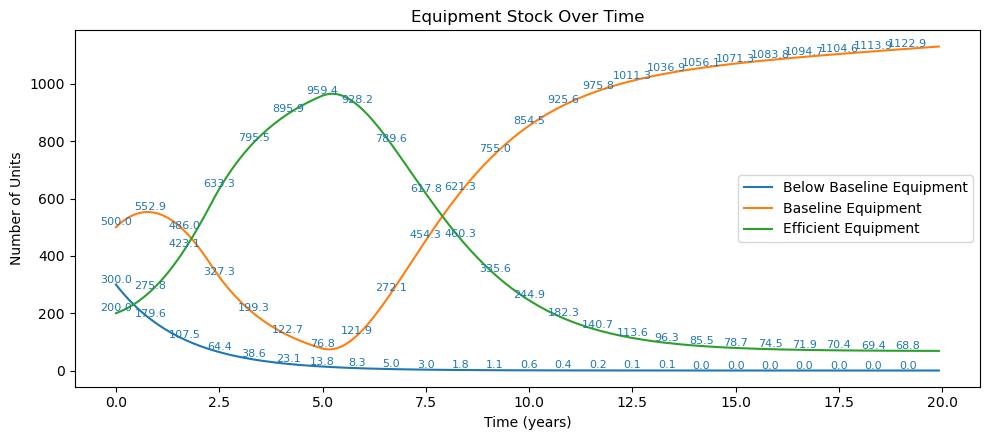

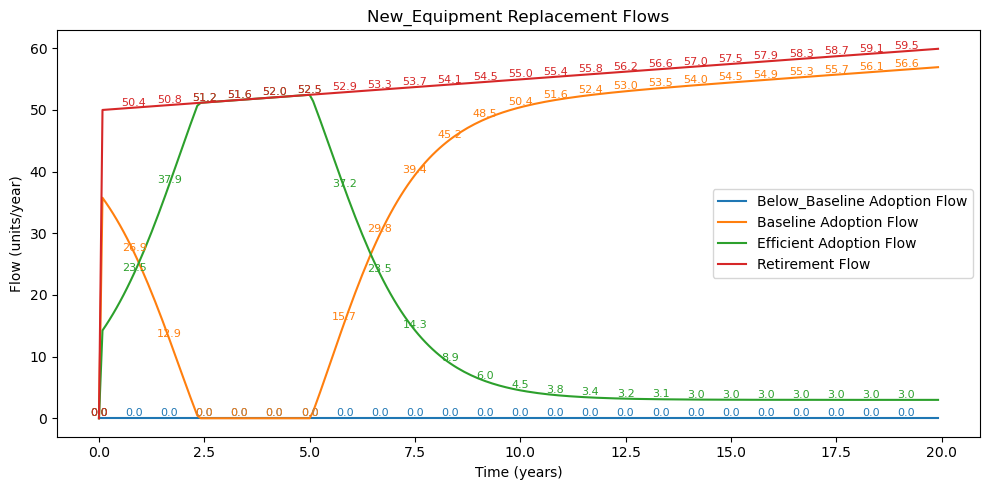

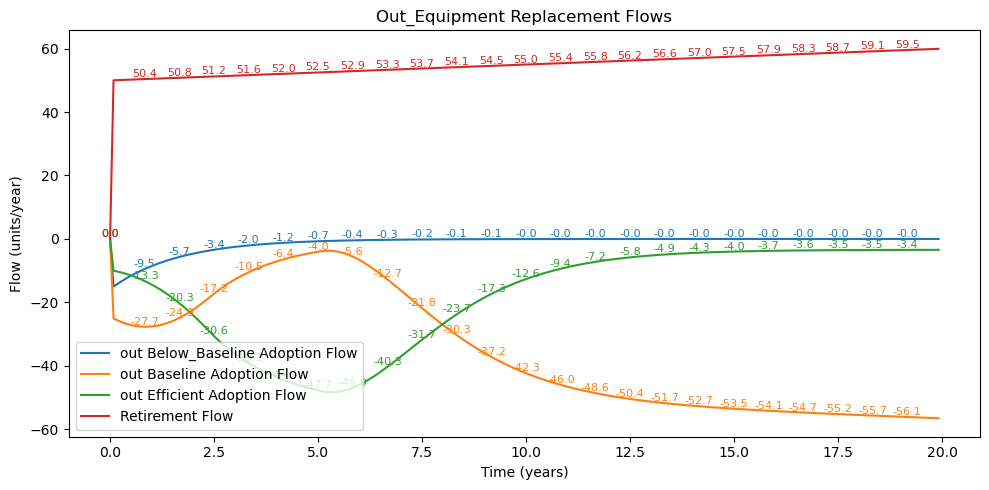

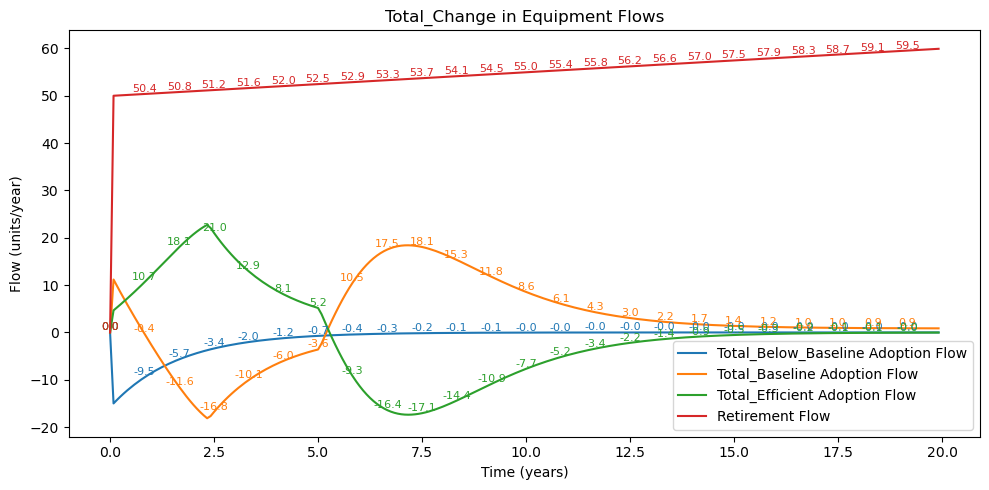

In [15]:
# Equipment Stocks
plt.figure(figsize=(10, 4.5))
plt.plot(time, Below_Baseline_Stock, label="Below Baseline Equipment")
plt.plot(time, Baseline_Stock, label="Baseline Equipment")
plt.plot(time, Efficient_Stock, label="Efficient Equipment")
for i in range(0, len(time), 10):
    plt.text(time[i], Efficient_Stock[i], f"{Efficient_Stock[i]:.1f}", 
             fontsize=8, ha='center', va='bottom', color='tab:blue')
    plt.text(time[i], Baseline_Stock[i], f"{Baseline_Stock[i]:.1f}", 
             fontsize=8, ha='center', va='bottom', color='tab:blue')
    plt.text(time[i], Below_Baseline_Stock[i], f"{Below_Baseline_Stock[i]:.1f}", 
             fontsize=8, ha='center', va='bottom', color='tab:blue')
plt.xlabel("Time (years)")
plt.ylabel("Number of Units")
plt.title("Equipment Stock Over Time")
plt.legend()
plt.tight_layout()
plt.show()

# New Equipment Flows
plt.figure(figsize=(10, 5))
plt.plot(time, Below_Baseline_Adoption_Flow_arr, label="Below_Baseline Adoption Flow")
plt.plot(time, Baseline_Adoption_Flow_arr, label="Baseline Adoption Flow")
plt.plot(time, Efficient_Adoption_Flow_arr, label="Efficient Adoption Flow")
plt.plot(time, Retirement_Flow_arr, label="Retirement Flow")

for i in range(0, len(time), 10):
    plt.text(time[i], Below_Baseline_Adoption_Flow_arr[i], f"{Below_Baseline_Adoption_Flow_arr[i]:.1f}", 
             fontsize=8, ha='center', va='bottom', color='tab:blue')
    plt.text(time[i], Baseline_Adoption_Flow_arr[i], f"{Baseline_Adoption_Flow_arr[i]:.1f}", 
             fontsize=8, ha='center', va='bottom', color='tab:orange')
    plt.text(time[i], Efficient_Adoption_Flow_arr[i], f"{Efficient_Adoption_Flow_arr[i]:.1f}", 
             fontsize=8, ha='center', va='bottom', color='tab:green')
    plt.text(time[i], Retirement_Flow_arr[i], f"{Retirement_Flow_arr[i]:.1f}", 
             fontsize=8, ha='center', va='bottom', color='tab:red')

plt.xlabel("Time (years)")
plt.ylabel("Flow (units/year)")
plt.title("New_Equipment Replacement Flows")
plt.legend()
plt.tight_layout()
plt.show()

# out Equipment Flows
plt.figure(figsize=(10, 5))
plt.plot(time, out_Below_Baseline_Adoption_Flow_arr, label="out Below_Baseline Adoption Flow")
plt.plot(time, out_Baseline_Adoption_Flow_arr, label="out Baseline Adoption Flow")
plt.plot(time, out_Efficient_Adoption_Flow_arr, label="out Efficient Adoption Flow")
plt.plot(time, Retirement_Flow_arr, label="Retirement Flow")

for i in range(0, len(time), 10):
    plt.text(time[i], out_Below_Baseline_Adoption_Flow_arr[i], f"{out_Below_Baseline_Adoption_Flow_arr[i]:.1f}", 
             fontsize=8, ha='center', va='bottom', color='tab:blue')
    plt.text(time[i], out_Baseline_Adoption_Flow_arr[i], f"{out_Baseline_Adoption_Flow_arr[i]:.1f}", 
             fontsize=8, ha='center', va='bottom', color='tab:orange')
    plt.text(time[i], out_Efficient_Adoption_Flow_arr[i], f"{out_Efficient_Adoption_Flow_arr[i]:.1f}", 
             fontsize=8, ha='center', va='bottom', color='tab:green')
    plt.text(time[i], Retirement_Flow_arr[i], f"{Retirement_Flow_arr[i]:.1f}", 
             fontsize=8, ha='center', va='bottom', color='tab:red')

plt.xlabel("Time (years)")
plt.ylabel("Flow (units/year)")
plt.title("Out_Equipment Replacement Flows")
plt.legend()
plt.tight_layout()
plt.show()

# Total Equipment Flows
plt.figure(figsize=(10, 5))
plt.plot(time, Total_Below_Baseline_Adoption_Flow_arr, label="Total_Below_Baseline Adoption Flow")
plt.plot(time, Total_Baseline_Adoption_Flow_arr, label="Total_Baseline Adoption Flow")
plt.plot(time, Total_Efficient_Adoption_Flow_arr, label="Total_Efficient Adoption Flow")
plt.plot(time, Retirement_Flow_arr, label="Retirement Flow")

for i in range(0, len(time), 10):
    plt.text(time[i], Total_Below_Baseline_Adoption_Flow_arr[i], f"{Total_Below_Baseline_Adoption_Flow_arr[i]:.1f}", 
             fontsize=8, ha='center', va='bottom', color='tab:blue')
    plt.text(time[i], Total_Baseline_Adoption_Flow_arr[i], f"{Total_Baseline_Adoption_Flow_arr[i]:.1f}", 
             fontsize=8, ha='center', va='bottom', color='tab:orange')
    plt.text(time[i], Total_Efficient_Adoption_Flow_arr[i], f"{Total_Efficient_Adoption_Flow_arr[i]:.1f}", 
             fontsize=8, ha='center', va='bottom', color='tab:green')
    plt.text(time[i], Retirement_Flow_arr[i], f"{Retirement_Flow_arr[i]:.1f}", 
             fontsize=8, ha='center', va='bottom', color='tab:red')

plt.xlabel("Time (years)")
plt.ylabel("Flow (units/year)")
plt.title("Total_Change in Equipment Flows")
plt.legend()
plt.tight_layout()
plt.show()


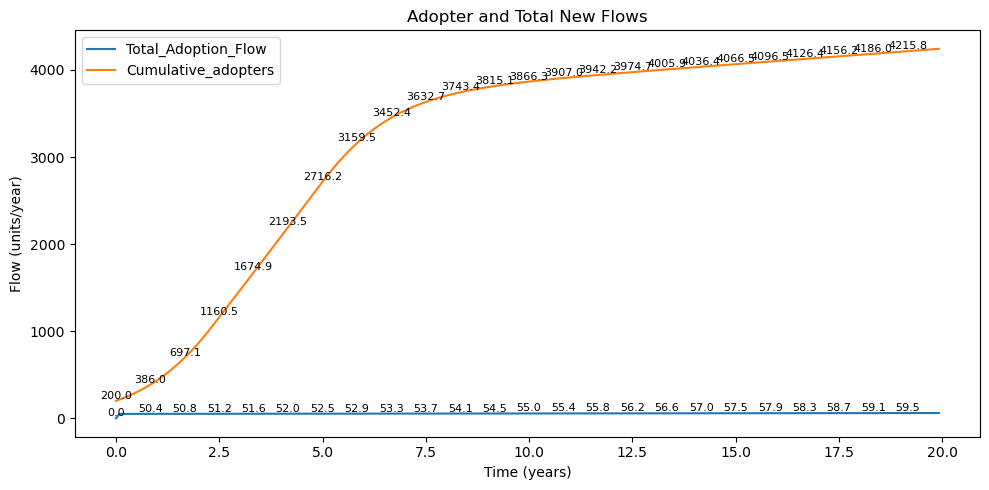

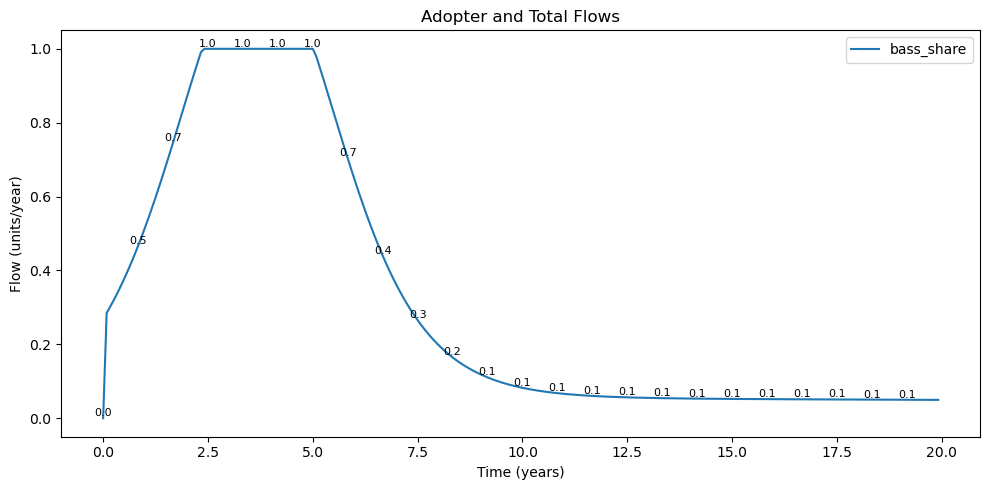

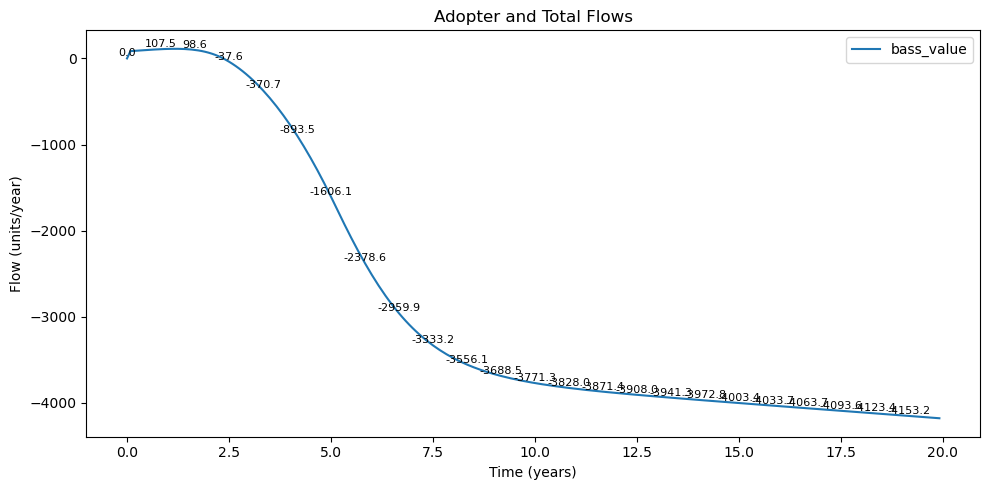

In [16]:
#Adopters
plt.figure(figsize=(10, 5))
plt.plot(time, Total_Adoption_Flow_arr, label="Total_Adoption_Flow")
# Add Y-value labels every 10th point
for i in range(0, len(time), 10):
    plt.text(time[i], Total_Adoption_Flow_arr[i], f"{Total_Adoption_Flow_arr[i]:.1f}", 
             fontsize=8, ha='center', va='bottom')
plt.plot(time, Cumulative_adopters, label="Cumulative_adopters")
# Add Y-value labels every 10th point
for i in range(0, len(time), 10):
    plt.text(time[i], Cumulative_adopters[i], f"{Cumulative_adopters[i]:.1f}", 
             fontsize=8, ha='center', va='bottom')
plt.xlabel("Time (years)")
plt.ylabel("Flow (units/year)")
plt.title("Adopter and Total New Flows")
plt.legend()
plt.tight_layout()
plt.show()


#Bass Flow
# Adopters
plt.figure(figsize=(10, 5))
plt.plot(time, bass_share_arr, label="bass_share")

# Add Y-value labels every 10th point
for i in range(0, len(time), 10):
    plt.text(time[i], bass_share_arr[i], f"{bass_share_arr[i]:.1f}", 
             fontsize=8, ha='center', va='bottom')
plt.xlabel("Time (years)")
plt.ylabel("Flow (units/year)")
plt.title("Adopter and Total Flows")
plt.legend()
plt.tight_layout()
plt.show()

#Bass values
# Adopters
plt.figure(figsize=(10, 5))
plt.plot(time, bass_value_arr, label="bass_value")

# Add Y-value labels every 10th point
for i in range(0, len(time), 10):
    plt.text(time[i], bass_value_arr[i], f"{bass_value_arr[i]:.1f}", 
             fontsize=8, ha='center', va='bottom')
plt.xlabel("Time (years)")
plt.ylabel("Flow (units/year)")
plt.title("Adopter and Total Flows")
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
bass_share_arr

array([0.        , 0.2848    , 0.30157068, 0.31916305, 0.33759609,
       0.3568862 , 0.37704678, 0.39808772, 0.42001477, 0.44282902,
       0.46652628, 0.49109639, 0.51652258, 0.5427808 , 0.56983905,
       0.5976567 , 0.62618386, 0.65536083, 0.6851175 , 0.715373  ,
       0.7460353 , 0.77700103, 0.80815544, 0.8393725 , 0.87051528,
       0.90143643, 0.93197901, 0.96197753, 0.99125921, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.97937837, 0.94966643, 0.91932799, 0.88854184,
       0.85747865, 0.82629952, 0.79515489, 0.76418367, 0.73351268,
       0.7032563 , 0.67351642, 0.64438249, 0.61593185, 0.58823